<a href="https://colab.research.google.com/github/shakasom/multilabel-landcover-deeplearning/blob/master/Multi_label_Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting Data

In [1]:
#!pip3 install matplotlib fastai seaborn torch pandas

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai import *
from fastai.callback import *
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd

In [4]:
# !wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
#!unzip UCMercedLanduse.zip


In [5]:
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
df.head()


,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
df.shape

(2100, 18)

In [7]:
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)
class_count

,class,Count
1,airplane,100
2,bare-soil,718
3,buildings,691
4,cars,886
5,chaparral,115
6,court,105
7,dock,100
8,field,103
9,grass,975
10,mobile-home,102


/Users/hotal/Desktop/MapHarvester/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hotal/Desktop/MapHarvester/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hotal/Desktop/MapHarvester/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


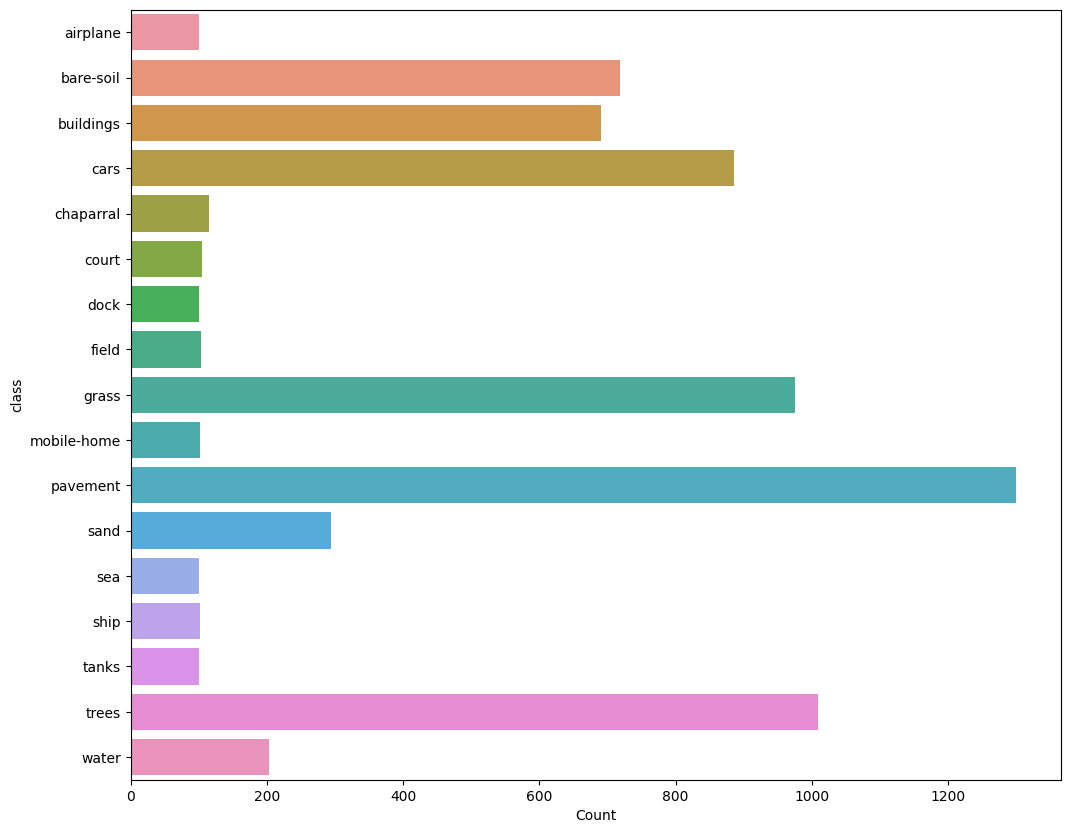

In [8]:
fig, ax= plt.subplots(figsize=(12,10))
sns.barplot(y="class", x="Count",  data=class_count, ax=ax);

In [9]:
list(class_count['class'])

['airplane',
 'bare-soil',
 'buildings',
 'cars',
 'chaparral',
 'court',
 'dock',
 'field',
 'grass',
 'mobile-home',
 'pavement',
 'sand',
 'sea',
 'ship',
 'tanks',
 'trees',
 'water']

### Training 

In [10]:
#!pip3 install chardet


In [11]:
df['all-labels'] = [ x.tolist() for x in  df.apply(lambda row: row[row == 1].index, axis=1)]


In [12]:
df['all-labels']= df['all-labels'].str.join(" ")

In [13]:
df

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water,all-labels
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,field trees
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,field
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,field
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,field
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,trees
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,tenniscourt95,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,bare-soil court grass pavement
2096,tenniscourt96,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0,bare-soil buildings cars court grass pavement ...
2097,tenniscourt97,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0,bare-soil buildings cars court grass pavement ...
2098,tenniscourt98,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0,bare-soil buildings cars court grass pavement ...


In [14]:
from fastai.vision.all import *

In [15]:
from sklearn.model_selection import train_test_split


In [16]:
# Define the getter for independent variable
def get_x(row): return 'UCMerced/images/'+row['IMAGE\LABEL']+'.tif'

# Define the getter for dependent variable
def get_y(row): row_df = pd.DataFrame(row).transpose(); return row_df.apply(lambda r: r[r == 1].index, axis=1)
# Define the getter for dependent variable
def get_y_v2(row): return row['all-labels'].split(" ")

# Define how to split the data into train and validation
def splitter(df):
    train, test = train_test_split(df, test_size=0.2)

    valid_idxs = test.index.tolist()
    train_idxs = train.index.tolist()
    
    return (train_idxs, valid_idxs)

In [17]:
get_x(df.iloc[0])

'UCMerced/images/agricultural00.tif'

In [18]:
get_y_v2(df.iloc[0])

['field', 'trees']

In [19]:
splitter(df)

([1912,
  828,
  576,
  1792,
  1069,
  1579,
  2063,
  688,
  471,
  774,
  897,
  880,
  642,
  858,
  629,
  809,
  309,
  1677,
  2041,
  327,
  1442,
  166,
  1916,
  1952,
  1118,
  655,
  156,
  1417,
  47,
  541,
  637,
  585,
  1997,
  458,
  1377,
  1435,
  1895,
  1221,
  242,
  176,
  199,
  1132,
  1203,
  1905,
  10,
  293,
  1536,
  1457,
  386,
  934,
  1951,
  1484,
  1500,
  863,
  417,
  57,
  1032,
  1217,
  1829,
  1123,
  1193,
  609,
  145,
  1165,
  506,
  1646,
  1400,
  1071,
  241,
  109,
  1526,
  279,
  903,
  1384,
  488,
  1550,
  1184,
  228,
  997,
  486,
  824,
  839,
  1418,
  2044,
  1154,
  422,
  871,
  1200,
  1279,
  1489,
  1374,
  1034,
  318,
  1266,
  1281,
  1698,
  684,
  1332,
  209,
  1103,
  1620,
  1121,
  1755,
  1362,
  1808,
  818,
  217,
  726,
  1479,
  742,
  1412,
  167,
  1389,
  664,
  1042,
  19,
  35,
  2080,
  1510,
  1480,
  958,
  1288,
  586,
  898,
  143,
  610,
  1715,
  1252,
  1613,
  274,
  970,
  466,
  1491,
  400,

In [20]:
get_x(df)
#get_y(df)

0       UCMerced/images/agricultural00.tif
1       UCMerced/images/agricultural01.tif
2       UCMerced/images/agricultural02.tif
3       UCMerced/images/agricultural03.tif
4       UCMerced/images/agricultural04.tif
                       ...                
2095     UCMerced/images/tenniscourt95.tif
2096     UCMerced/images/tenniscourt96.tif
2097     UCMerced/images/tenniscourt97.tif
2098     UCMerced/images/tenniscourt98.tif
2099     UCMerced/images/tenniscourt99.tif
Name: IMAGE\LABEL, Length: 2100, dtype: object

In [21]:
item_tfms = RandomResizedCrop(460, min_scale=0.35),
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

batch_tfms[0]

Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 

In [22]:
# Define a multicategory block with presizing
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(0.2),
                   get_x=get_x,
                   get_y=get_y_v2,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms
                  )




In [23]:
dls = dblock.dataloaders(df, bs = 32)


: 

In [ ]:
len(dls.train_ds), len(dls.valid_ds)


(1680, 420)

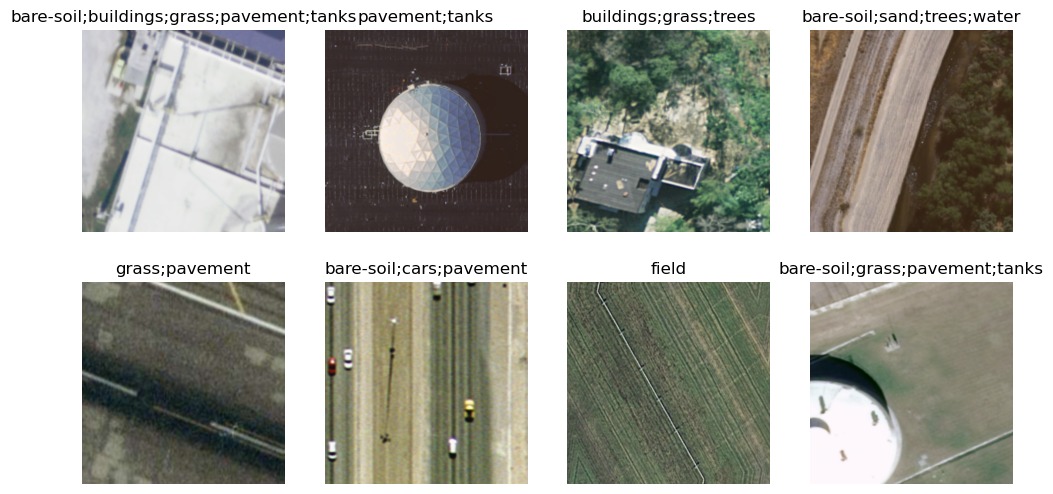

In [ ]:
dls.show_batch(nrows=2, ncols=4)


# Model Training

/Users/mcanbaz/opt/anaconda3/envs/fastAI-/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/mcanbaz/opt/anaconda3/envs/fastAI-/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Users/mcanbaz/opt/anaconda3/envs/fastAI-/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date 

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


SuggestedLRs(valley=0.0012022644514217973)

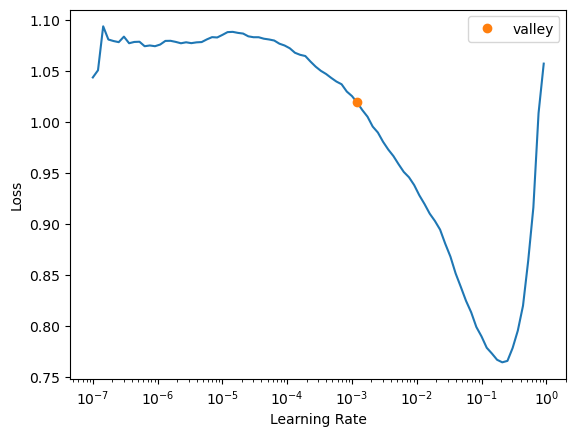

In [ ]:

learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.lr_find()

In [ ]:
learn.fine_tune(epochs = 5, freeze_epochs = 5, base_lr = 1e-3)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.933504,0.638876,0.662185,25:10
1,0.806481,0.524661,0.741036,25:14
2,0.695786,0.439461,0.810644,25:07
3,0.579306,0.334537,0.889496,25:10
4,0.436257,0.212172,0.943417,24:50


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.282730,0.175705,0.949720,37:33
1,0.245290,0.147420,0.952101,39:09
2,0.204808,0.123736,0.957843,37:45
3,0.171510,0.118246,0.957983,2:44:56
4,0.153868,0.115361,0.958683,2:56:38


In [ ]:
f_scorae = partial(fbeta, thresh=0.45)
learn = cnn_learner(data, models.resnet34, metrics=[accuracy_thresh, f_score],
                    callback_fns=[ShowGraph, SaveModelCallback])

In [ ]:
learn.lr_find()


In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

### Prediction

In [ ]:
!wget https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
!unzip test.zip

In [ ]:
img = open_image("/content/test/roundabout_086.jpg")
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

In [ ]:

img = open_image("/content/test/airplane_439.jpg")
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class